In [1]:
import pandas as pd
import os
import numpy as np
import argparse
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import functools
import urllib
import urllib.request
from multiprocessing.dummy import Pool as ThreadPool 
sns.set(style='darkgrid', context='talk')


In [2]:
"""Get 100kb window fst files"""
data_dir = '/Users/home/data'
fst_files = []
for file in os.listdir(data_dir '/fst_calc/'):
    if file.endswith("_all_100kb.windowed.weir.fst"):
        base=os.path.basename(file)
        #print(base.split('.')[0])


['baillif_v_capesterre_all_100kb',
 'baillif_v_col_des_mammelles_all_100kb',
 'baillif_v_desvariuex_all_100kb',
 'baillif_v_pointe_a_pitre_all_100kb',
 'capesterre_v_col_des_mammelles_all_100kb',
 'capesterre_v_desvariuex_all_100kb',
 'capesterre_v_pointe_a_pitre_all_100kb',
 'col_des_mammelles_v_desvariuex_all_100kb',
 'col_des_mammelles_v_pointe_a_pitre_all_100kb',
 'desvariuex_v_pointe_a_pitre_all_100kb']

In [3]:
"""Calculate values which we will set as high, intermediate, and low fst value for each of the location comparisons"""
fst_dict = {}
def calculate_outliers(fst_files):
    for file in fst_files:
        fst_dict[file] = pd.read_csv('/Users/admin_will/Documents/will/ano_mar/data/pop_gen_calc/fst_calc/' + file + '.windowed.weir.fst', sep='\t') 
        fst_dict[file]['pos_mean'] = np.where(fst_dict[file]['MEAN_FST'] <= 0, 0, fst_dict[file]['MEAN_FST'])
        ninety_nine = fst_dict[file]['pos_mean'].quantile(0.99)
        ninety_five = fst_dict[file]['pos_mean'].quantile(0.95)
        print(ninety_nine)
        fst_dict[file]['outlier'] = np.where(fst_dict[file]['pos_mean'] > ninety_five, 'intermediate', 'low') 
        fst_dict[file]['outlier'] = np.where(fst_dict[file]['pos_mean'] > ninety_nine, 'high', fst_dict[file]['outlier'])
        fst_dict[file]['location'] = file
    return fst_dict

fst_dict = calculate_outliers(fst_files)


0.0
0.0
0.09072819899999963
0.019067278000000056
0.015464994999999974
0.10078324999999999
0.05648327499999991
0.043939649999999955
0.009909265499999974
0.01816015300000002


In [6]:
weighted_fst_dict = {}
def calculate_outliers(fst_files):
    for file in fst_files:
        weighted_fst_dict[file] = pd.read_csv('/Users/admin_will/Documents/will/ano_mar/data/pop_gen_calc/fst_calc/' + file + '.windowed.weir.fst', sep='\t') 
        weighted_fst_dict[file]['weighted_pos'] = np.where(weighted_fst_dict[file]['WEIGHTED_FST'] <= 0, 0, weighted_fst_dict[file]['WEIGHTED_FST'])
        stdev = np.std(weighted_fst_dict[file]['weighted_pos'])
        mean = np.mean(weighted_fst_dict[file]['weighted_pos'])
        print(file, mean)
        weighted_fst_dict[file]['sdev_outlier'] = np.where(weighted_fst_dict[file]['weighted_pos'] > (mean + 3*stdev), 'intermediate', 'low')
        weighted_fst_dict[file]['sdev_outlier'] = np.where(weighted_fst_dict[file]['weighted_pos'] > (mean + 5*stdev), 'high', weighted_fst_dict[file]['sdev_outlier'])
        weighted_fst_dict[file]['location'] = file
    return weighted_fst_dict

weighted_fst_dict = calculate_outliers(fst_files)

baillif_v_capesterre_all_100kb 0.03874841229846018
baillif_v_col_des_mammelles_all_100kb 0.029939219531010582
baillif_v_desvariuex_all_100kb 0.08276707029478234
baillif_v_pointe_a_pitre_all_100kb 0.06453762332294025
capesterre_v_col_des_mammelles_all_100kb 0.0439522145116071
capesterre_v_desvariuex_all_100kb 0.06855650684828087
capesterre_v_pointe_a_pitre_all_100kb 0.04522155977366529
col_des_mammelles_v_desvariuex_all_100kb 0.050275450520564195
col_des_mammelles_v_pointe_a_pitre_all_100kb 0.04441749067030148
desvariuex_v_pointe_a_pitre_all_100kb 0.016196235761771045


In [5]:
def combine_outliers(fst_dict):
    outlier_dict = {}
    for key in fst_dict:
        ninety_five = fst_dict[key]['pos_mean'].quantile(0.95)
        outlier_dict[key] = fst_dict[key][fst_dict[key]['pos_mean'] > ninety_five]
            
    key_list = list(outlier_dict.keys())
    outlier_dfs = [outlier_dict[x] for x in key_list]
    merged_outlier_dfs = pd.concat(outlier_dfs).reset_index(drop=True)
    return merged_outlier_dfs

combined_outliers_df = combine_outliers(fst_dict)

In [6]:
#combined_outliers_df[combined_outliers_df['location'].str.contains('capesterre')]

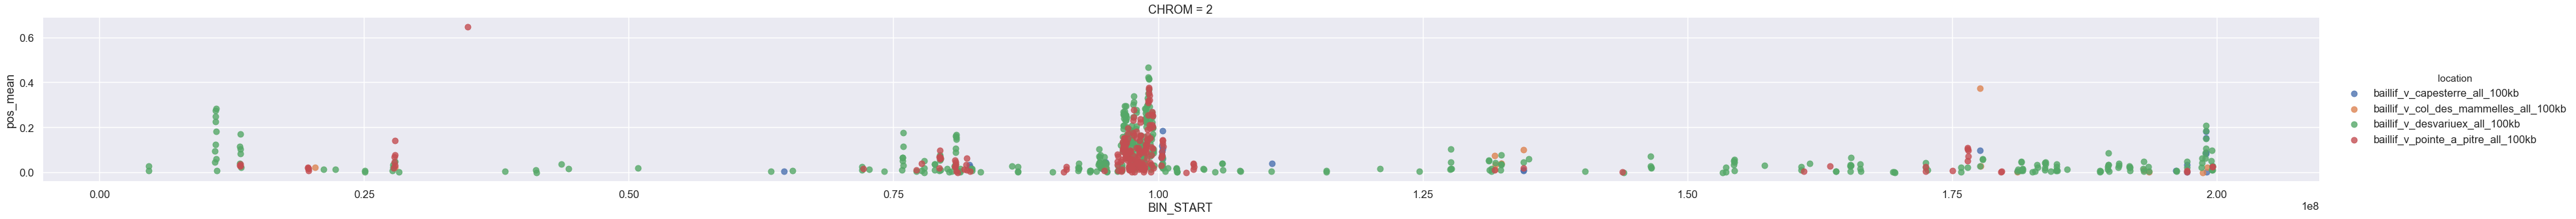

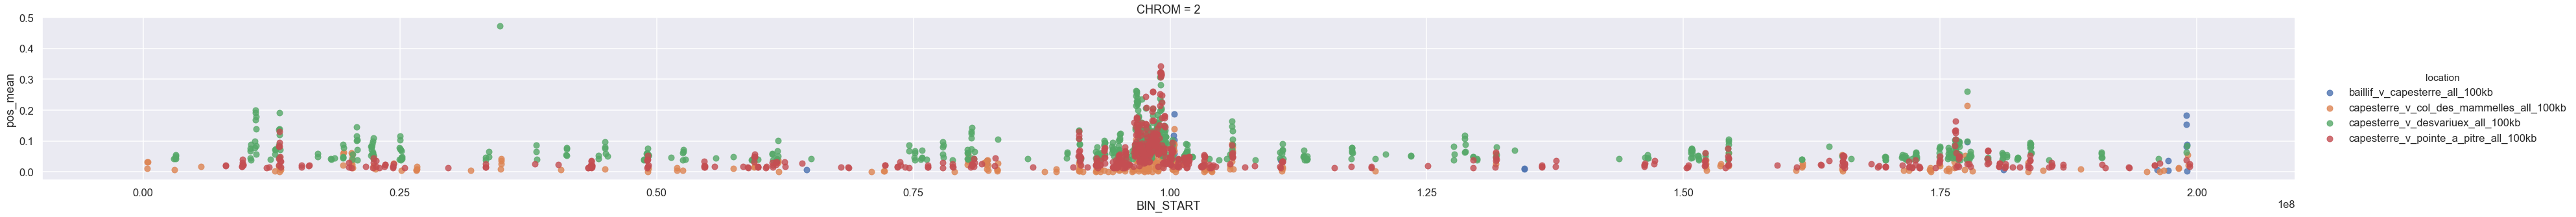

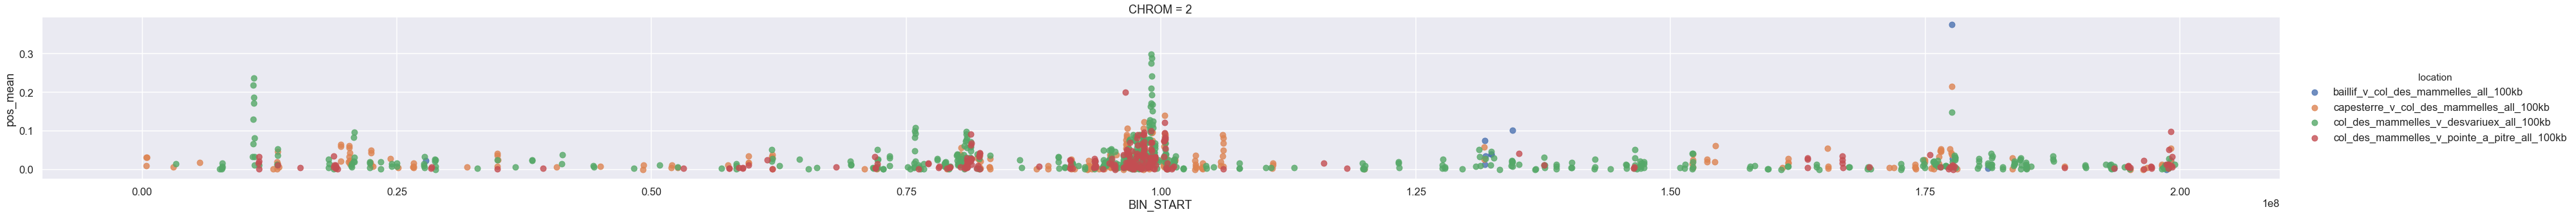

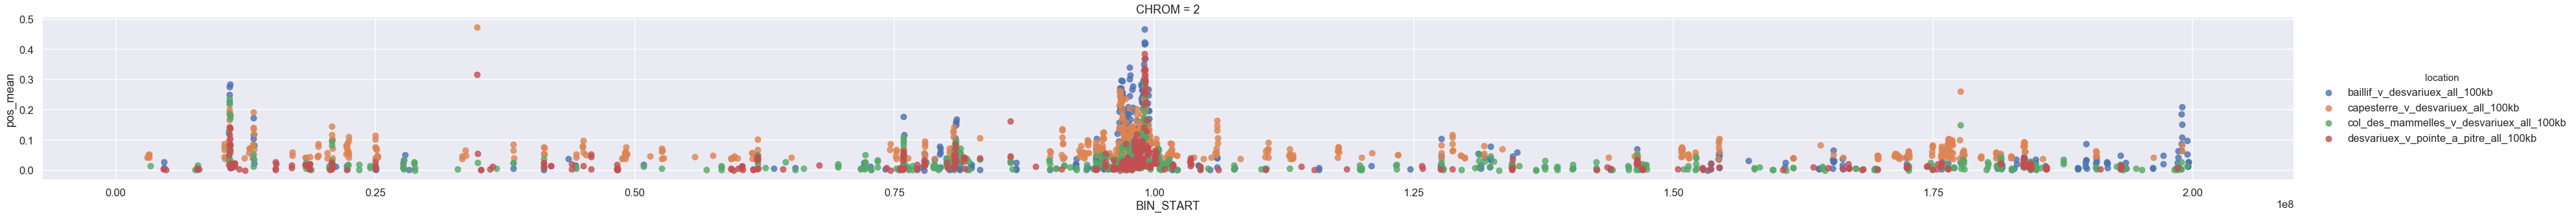

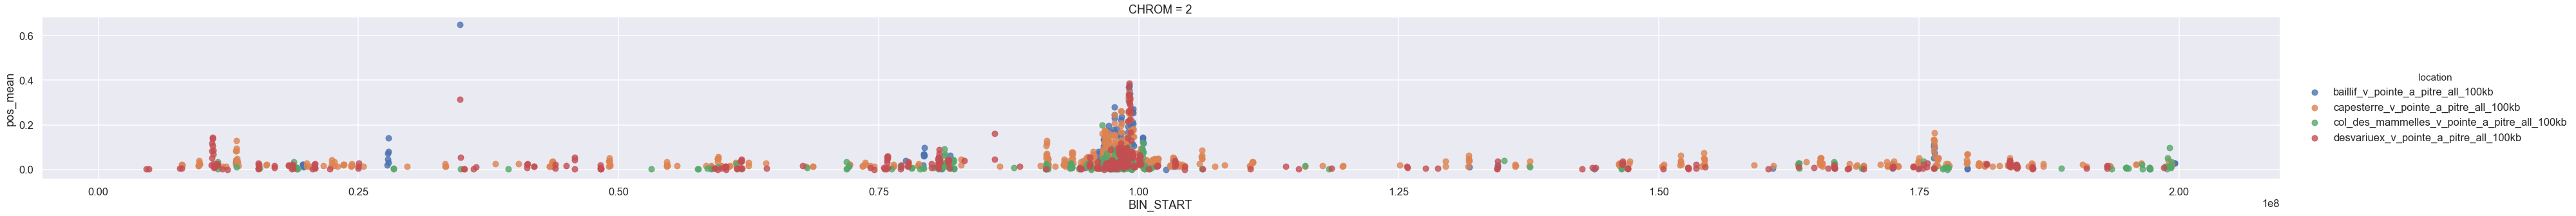

In [7]:
def plot_by_location(combined_frame):
    locations = ['baillif', 'capesterre', 'col_des_mammelles', 'desvariuex', 'pointe_a_pitre']
    for i in locations:
        loc_df = combined_frame[combined_frame['location'].str.contains(i)]
        g = sns.lmplot(x="BIN_START", y="pos_mean", hue="location", col="CHROM", fit_reg=False,
               data=loc_df[loc_df['CHROM']==2], aspect=10)

plot_by_location(combined_outliers_df)
#combined_outliers_df.info()
#combined_outliers_df[combined_outliers_df['outlier'] == 'high']

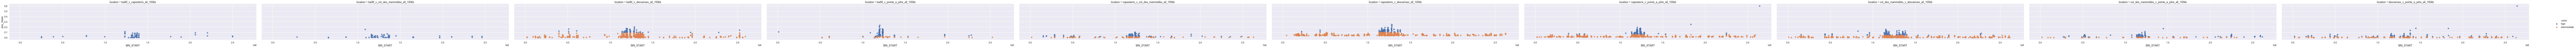

In [8]:
g = sns.lmplot(x="BIN_START", y="pos_mean", hue="outlier", col="location", fit_reg=False,
               data=combined_outliers_df[combined_outliers_df['CHROM']==1], aspect=5)

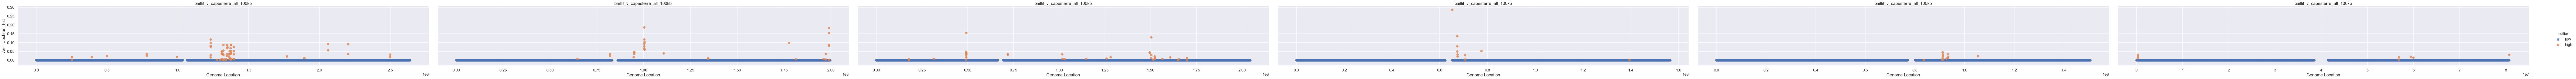

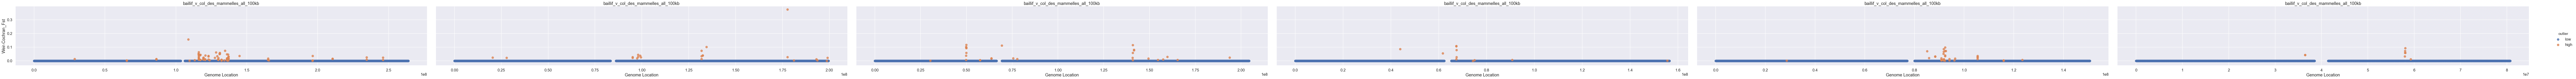

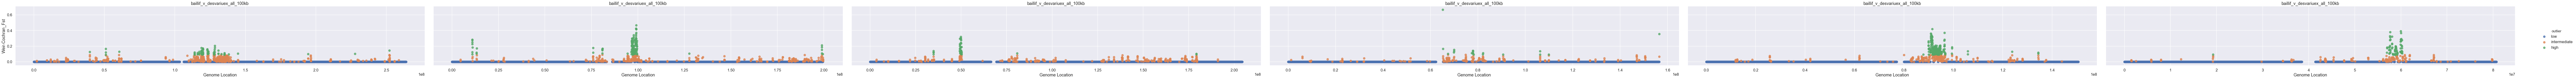

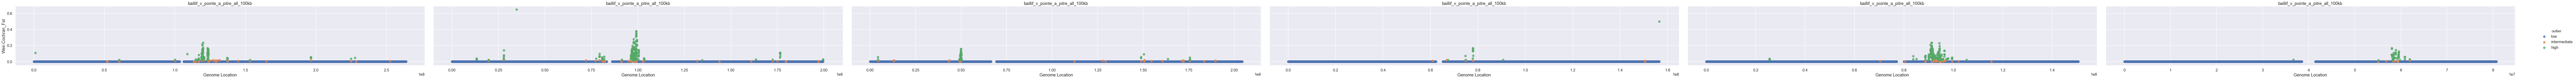

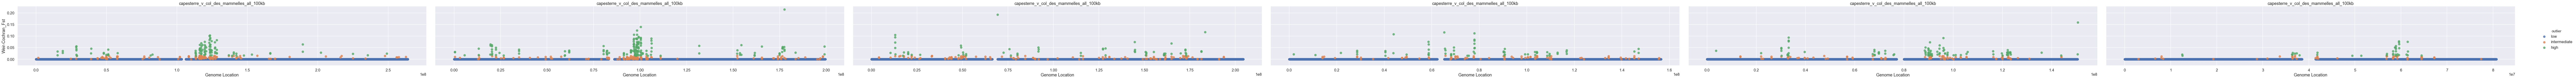

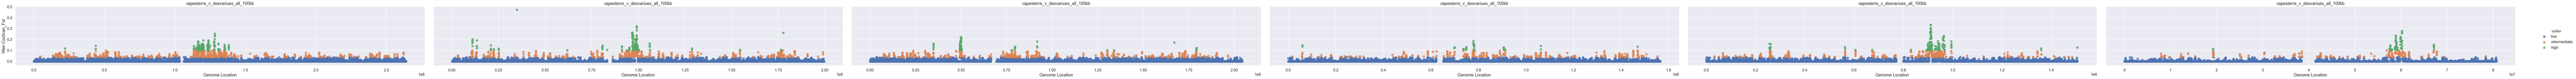

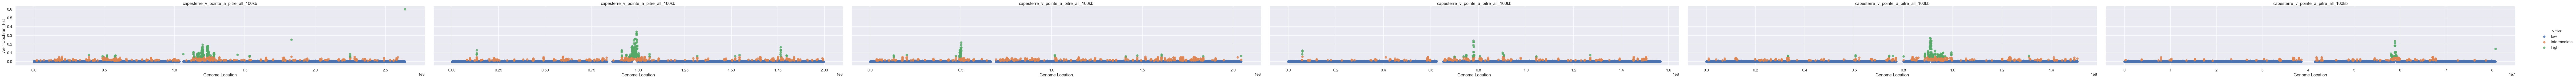

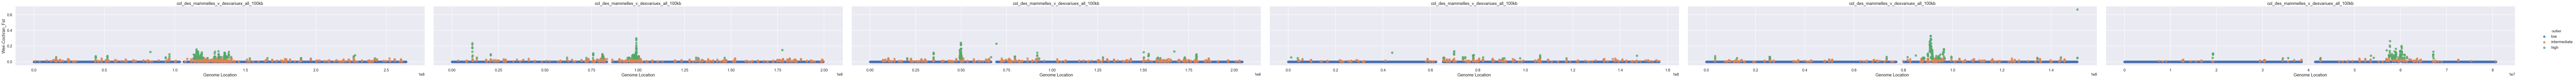

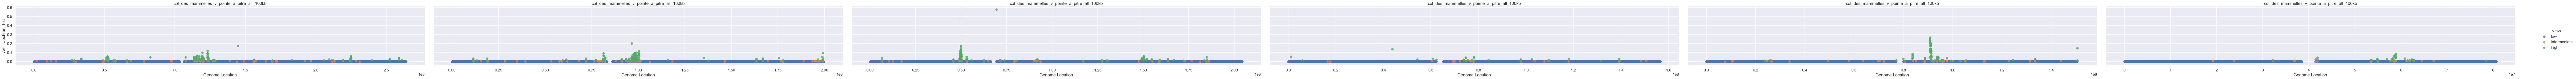

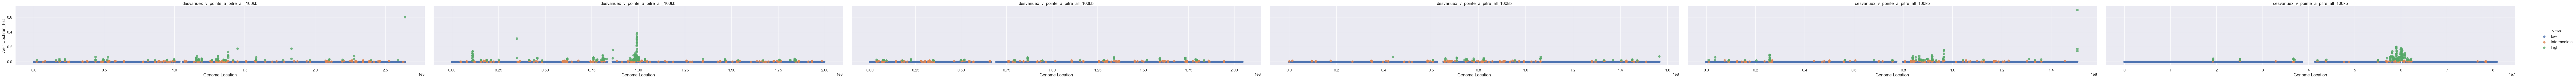

In [9]:
for key in fst_dict:
    g = sns.lmplot(x="BIN_START", y="pos_mean", hue="outlier", col="CHROM", fit_reg=False, 
                   data=fst_dict[key][fst_dict[key]['CHROM'] <= 6].sort_values(by=['outlier'],ascending=False),
                   sharex=False, aspect=5)
    g.set_titles(key)
    g = (g.set_axis_labels("Genome Location", "Weir-Cochran_Fst"))
    g.savefig('/Users/admin_will/Documents/will/ano_mar/data/pop_gen_calc/fst_plots/' + key + '.png')

In [10]:
for key in fst_dict:
    stdev = np.std(fst_dict[key]['pos_mean'])
    mean = np.mean(fst_dict[key]['pos_mean'])
    fst_dict[key]['sdev_outlier'] = np.where(fst_dict[key]['pos_mean'] > (mean + 3*stdev), 'intermediate', 'low')
    fst_dict[key]['sdev_outlier'] = np.where(fst_dict[key]['pos_mean'] > (mean + 5*stdev), 'high', fst_dict[key]['sdev_outlier'])
    #print(np.std(fst_dict[key]['pos_mean']))
    #print(np.mean(fst_dict[key][fst_dict[key]['outlier'] != 'low']['pos_mean']), key)
    print(key, mean)

baillif_v_capesterre_all_100kb 0.0001399133178639423
baillif_v_col_des_mammelles_all_100kb 0.00013985474187699093
baillif_v_desvariuex_all_100kb 0.0025920544222913363
baillif_v_pointe_a_pitre_all_100kb 0.0009324760019772312
capesterre_v_col_des_mammelles_all_100kb 0.0004773734247474373
capesterre_v_desvariuex_all_100kb 0.006478974483808034
capesterre_v_pointe_a_pitre_all_100kb 0.0023886540037198287
col_des_mammelles_v_desvariuex_all_100kb 0.0014734814721673328
col_des_mammelles_v_pointe_a_pitre_all_100kb 0.0004793243900767115
desvariuex_v_pointe_a_pitre_all_100kb 0.000680400267374949


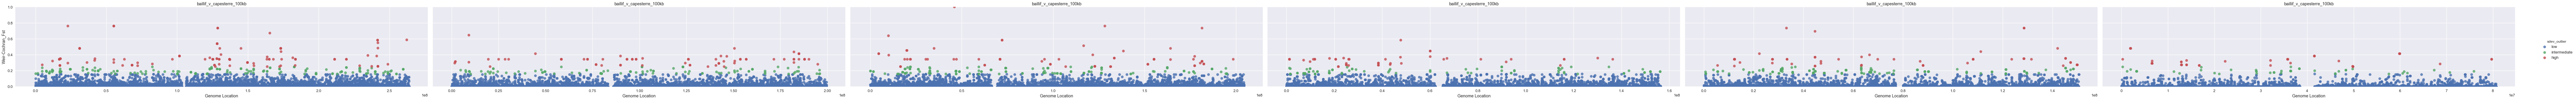

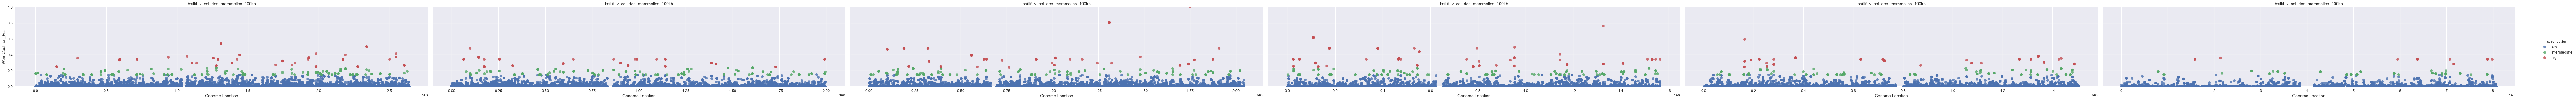

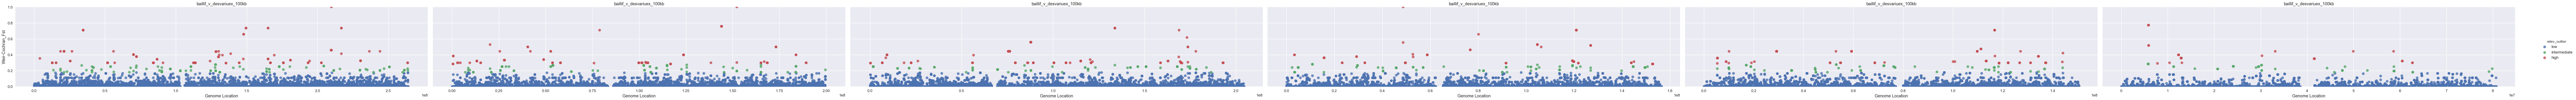

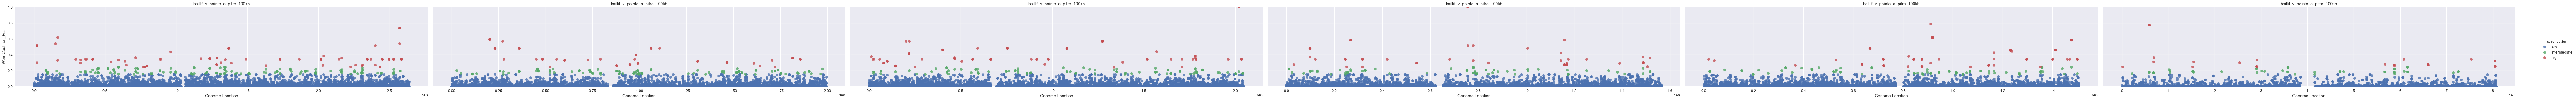

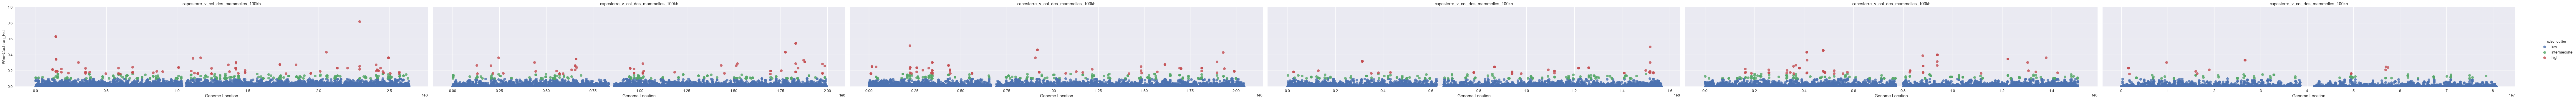

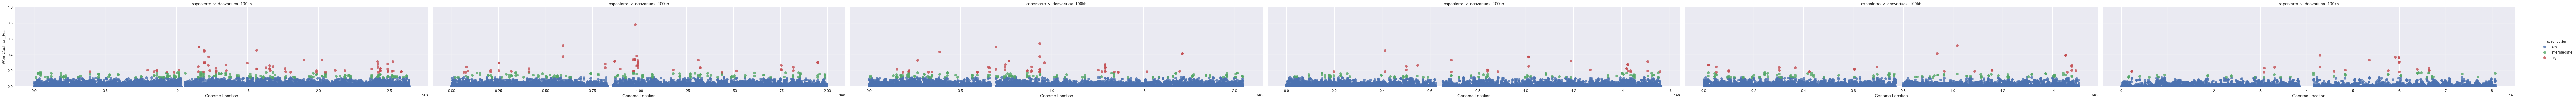

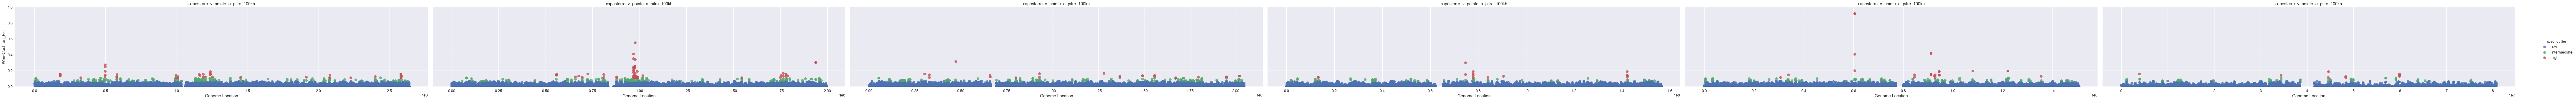

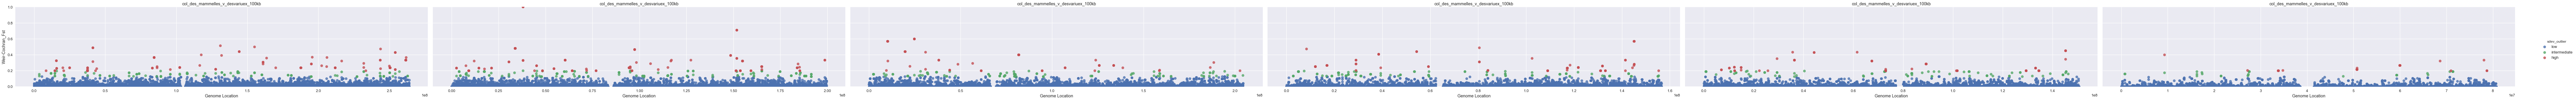

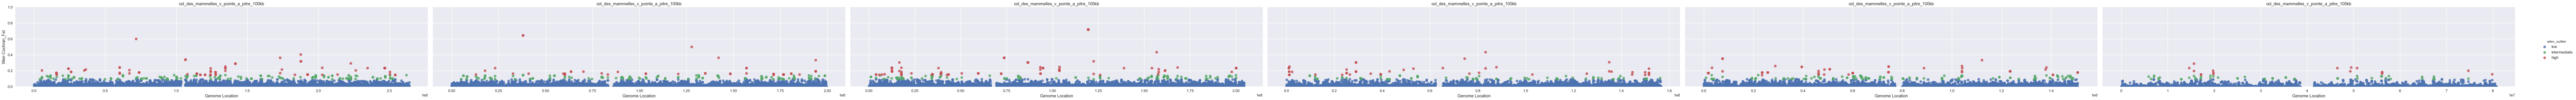

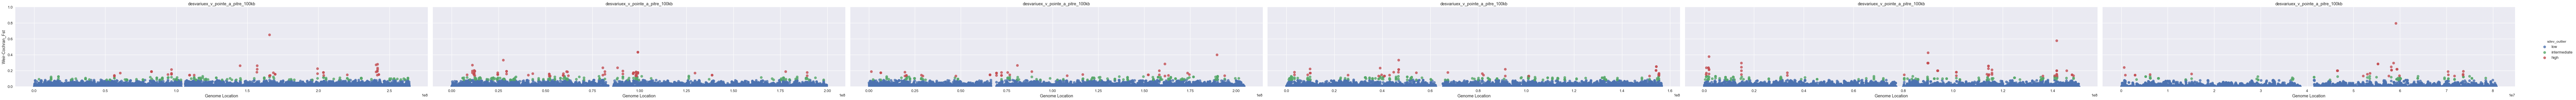

In [6]:
for key in fst_dict:
    g = sns.lmplot(x="BIN_START", y="pos_mean", hue="sdev_outlier", col="CHROM", fit_reg=False, 
                   data=fst_dict[key][fst_dict[key]['CHROM'] <= 6].sort_values(by=['sdev_outlier'],ascending=False),
                   sharex=False, aspect=4)
    g.set_titles(key)
    g = (g.set_axis_labels("Genome Location", "Weir-Cochran_Fst"))
    g.set(ylim=(0,1))
    g.savefig('/Users/admin_will/Documents/will/ano_mar/data/pop_gen_calc/fst_plots/' + key + '_sdev_outliers.png')

baillif_v_capesterre_all_100kb
baillif_v_col_des_mammelles_all_100kb
baillif_v_desvariuex_all_100kb
baillif_v_pointe_a_pitre_all_100kb
capesterre_v_col_des_mammelles_all_100kb
capesterre_v_desvariuex_all_100kb
capesterre_v_pointe_a_pitre_all_100kb
col_des_mammelles_v_desvariuex_all_100kb
col_des_mammelles_v_pointe_a_pitre_all_100kb
desvariuex_v_pointe_a_pitre_all_100kb


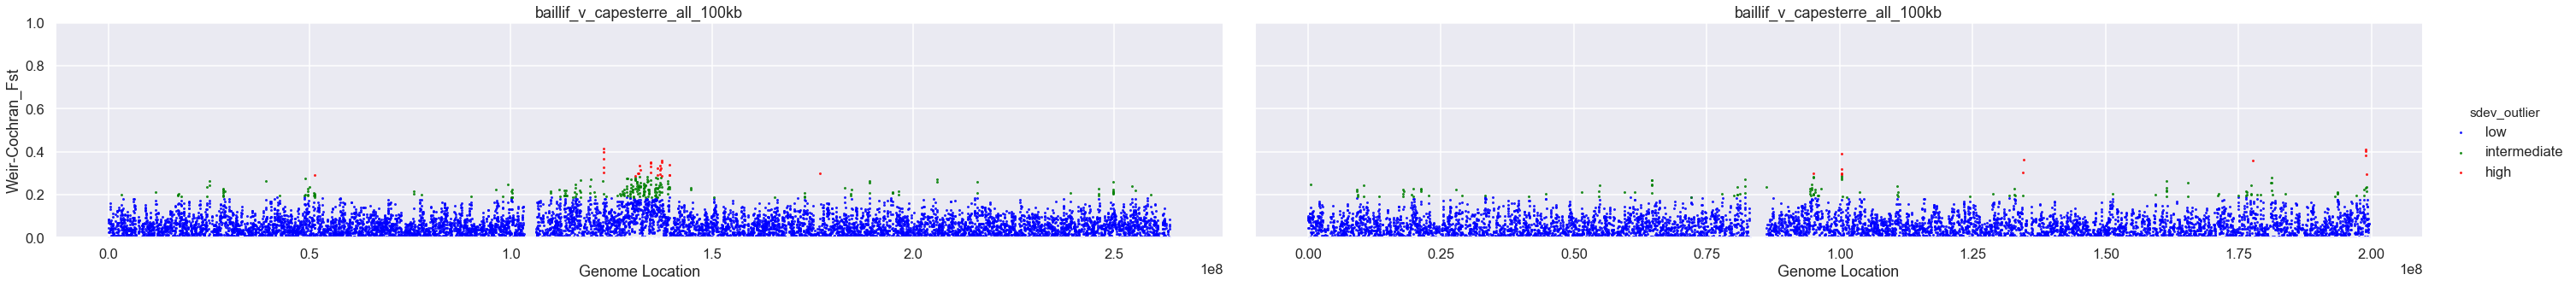

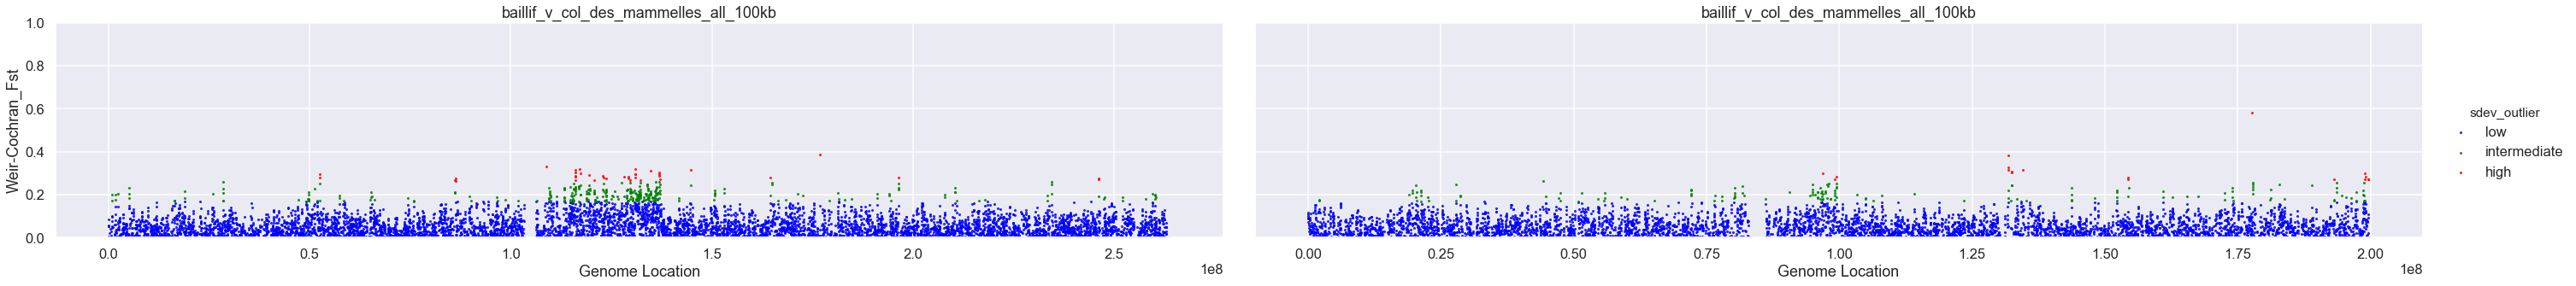

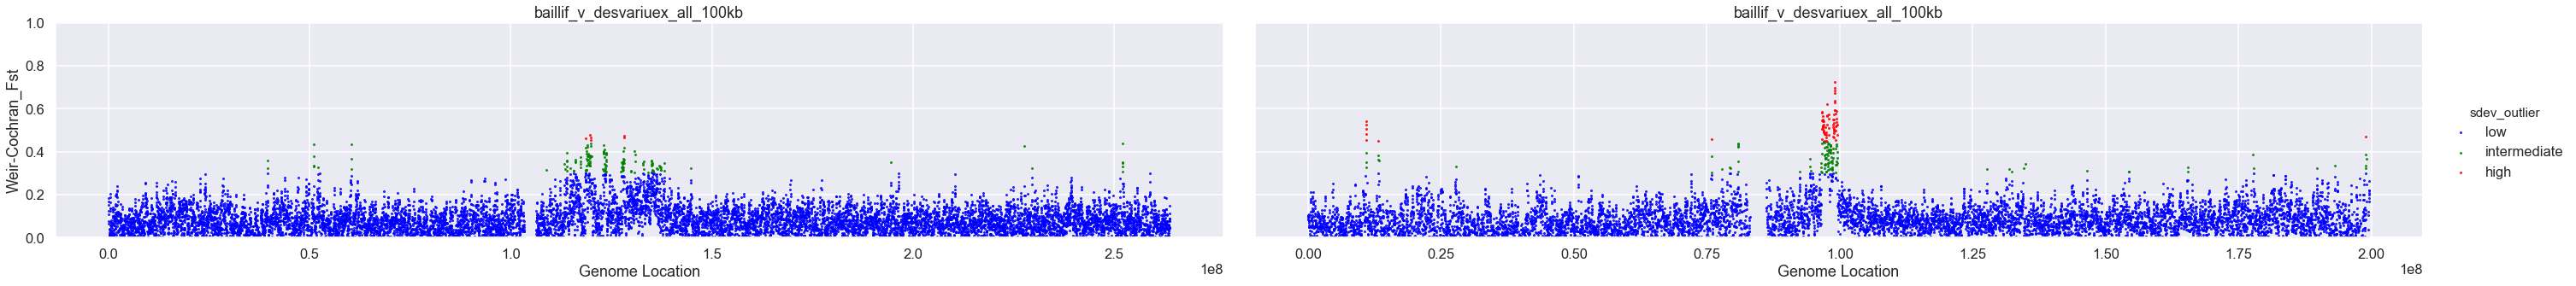

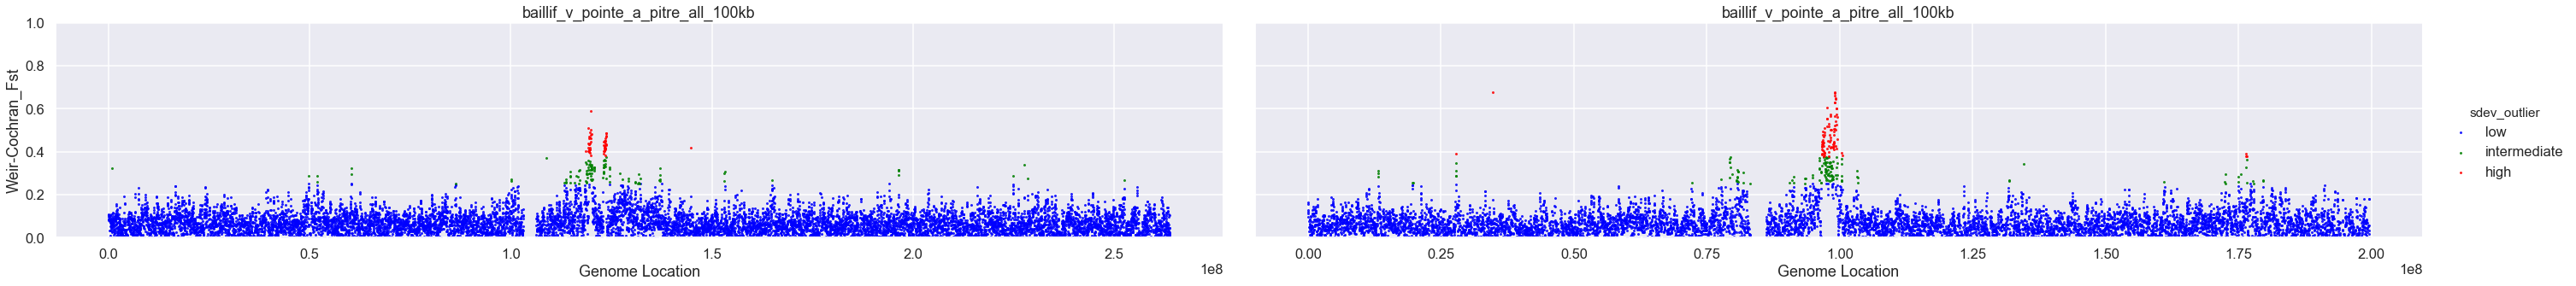

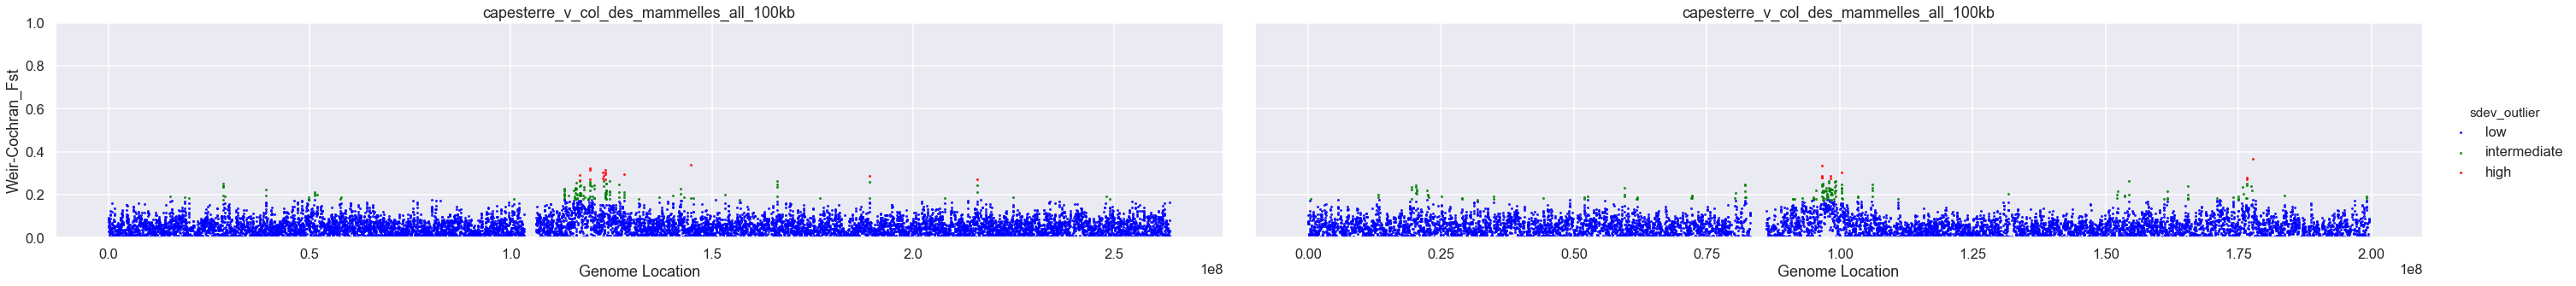

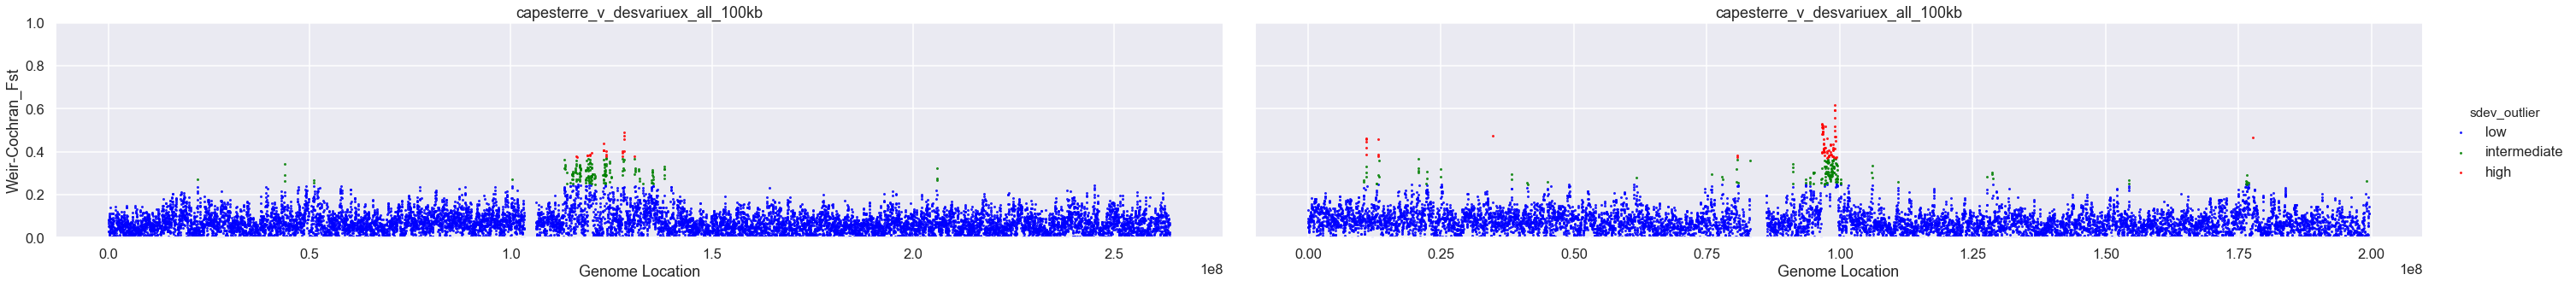

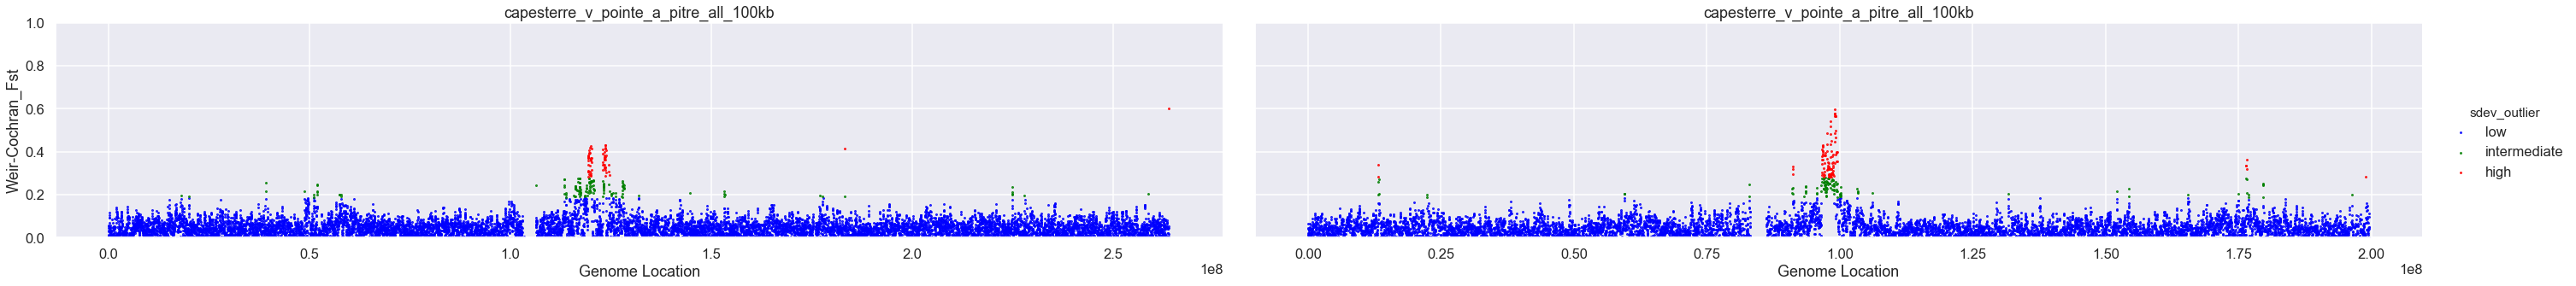

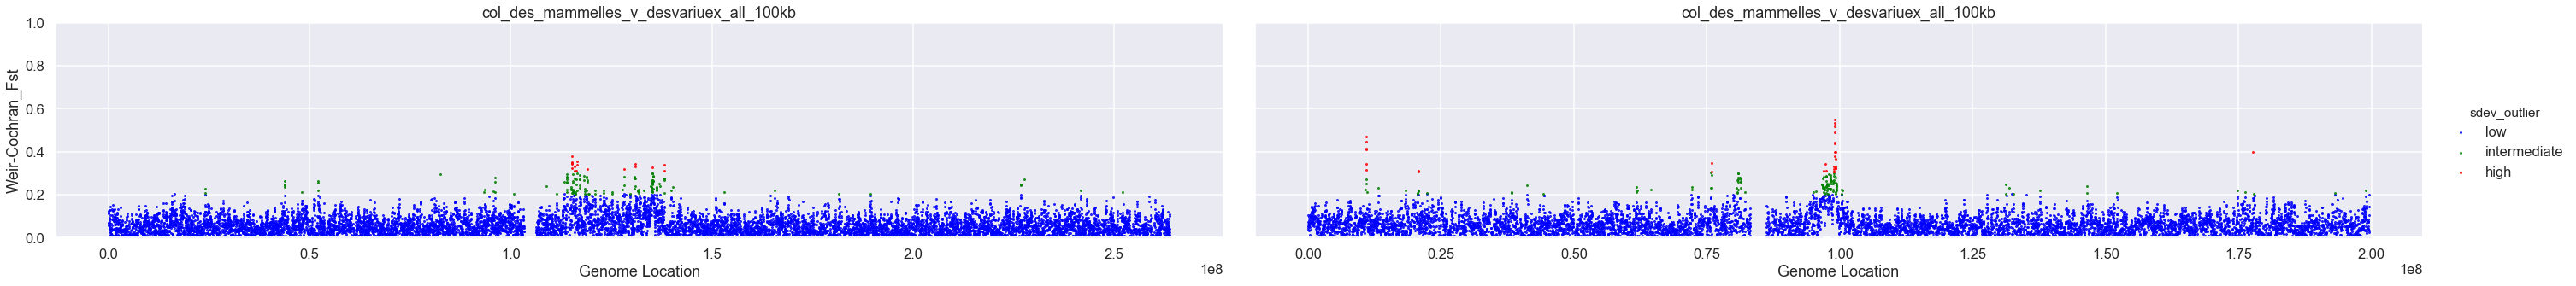

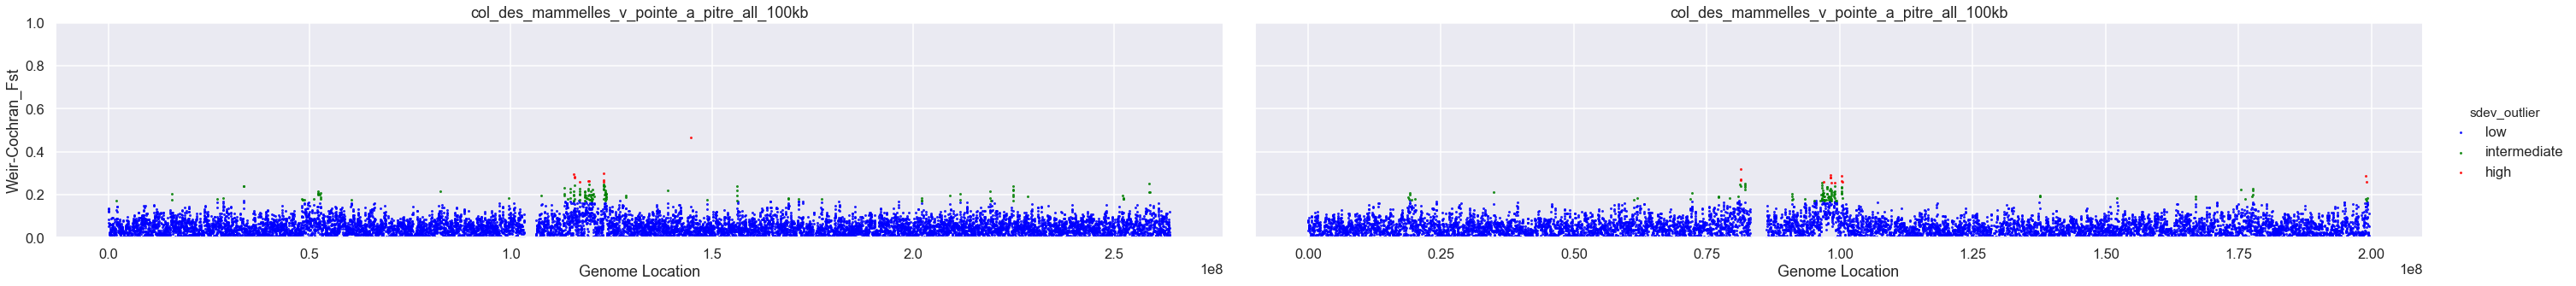

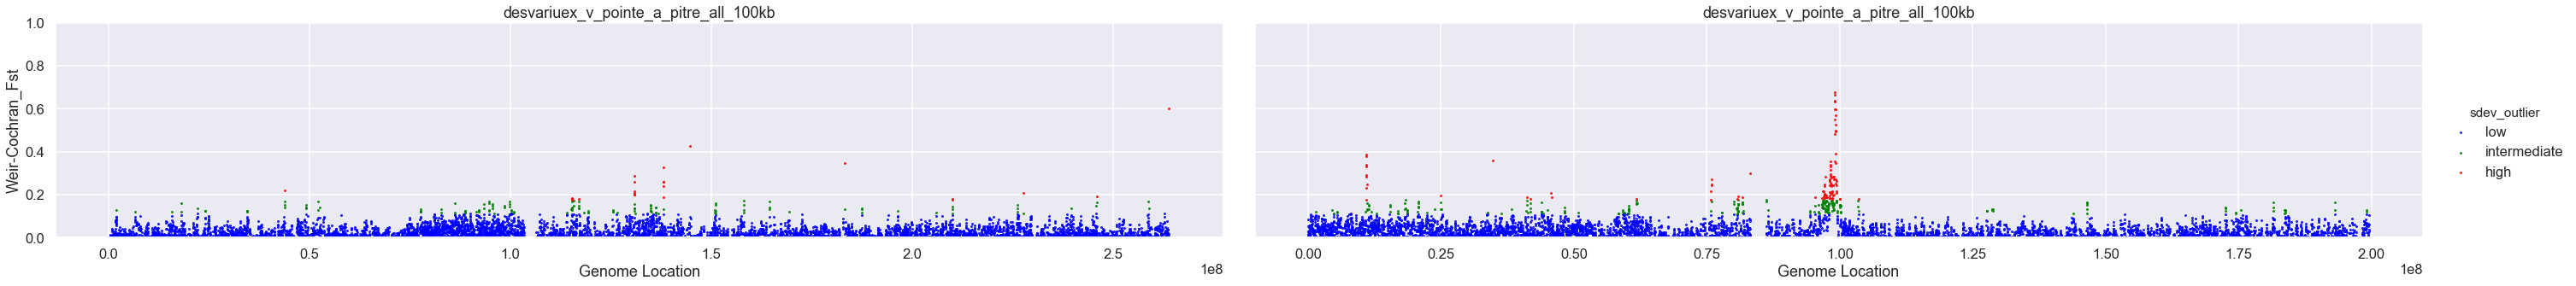

In [18]:
colors = ['blue', 'green', 'red']
for key in weighted_fst_dict:
    print(key)
    g = sns.lmplot(x="BIN_START", y="weighted_pos", hue="sdev_outlier", col="CHROM", fit_reg=False, 
                   data=weighted_fst_dict[key][weighted_fst_dict[key]['CHROM'] <= 2].sort_values(by=['sdev_outlier'],ascending=False),
                   sharex=False, aspect=4, palette=colors, scatter_kws={'s':4})
    g.set_titles(key)
    g = (g.set_axis_labels("Genome Location", "Weir-Cochran_Fst"))
    g.set(ylim=(0,1))
    g.savefig('/Users/admin_will/Documents/will/ano_mar/data/pop_gen_calc/fst_plots/all_100_kb_weighted_chrom1_2/' + key + '_weighted_sdev_outliers.png')

In [27]:
for key in weighted_fst_dict:
    mean = np.mean(weighted_fst_dict[key]['weighted_pos'])
    print(key, mean)

baillif_v_capesterre_all_100kb 0.03874841229846018
baillif_v_col_des_mammelles_all_100kb 0.029939219531010582
baillif_v_desvariuex_all_100kb 0.08276707029478234
baillif_v_pointe_a_pitre_all_100kb 0.06453762332294025
capesterre_v_col_des_mammelles_all_100kb 0.0439522145116071
capesterre_v_desvariuex_all_100kb 0.06855650684828087
capesterre_v_pointe_a_pitre_all_100kb 0.04522155977366529
col_des_mammelles_v_desvariuex_all_100kb 0.050275450520564195
col_des_mammelles_v_pointe_a_pitre_all_100kb 0.04441749067030148
desvariuex_v_pointe_a_pitre_all_100kb 0.016196235761771045


In [43]:
"""calculating mean fst for regions not in the outliers"""
"""reading in bed file of outlier regions + 1mb"""
outlier_bed = pd.read_excel('/Users/admin_will/Documents/will/ano_mar/data/annotations/full_nonredundant_outlier_bed_file_edited.xlsx',
                           header=None, names=['CHROM', 'BIN_START', 'BIN_END']) 
# weighted_fst_dict.keys()
test = weighted_fst_dict['baillif_v_capesterre_all_100kb']
# outlier_bed
test[(test['CHROM']==1) & (test['BIN_START'] > 100000) & (test['BIN_END'] < 10000000)]
for index, row in outlier_bed.iterrows():
    chrom, start, end = row[['CHROM', 'BIN_START', 'BIN_END']]
#     print(chrom, start, end)

def outlier_fst_calc(fst_dict, outlier_bed):
    outlier_fst_dict = {}
    neutral_fst_dict = {}
    for key in fst_dict:
        outlier_fst_df = pd.DataFrame(columns = ['CHROM' 'BIN_START', 'BIN_END', 'N_VARIANTS', 'WEIGHTED_FST', 'MEAN_FST',
                                                 'weighted_pos', 'sdev_outlier', 'location'])
#         outlier_fst_df.columns = ['CHROM' 'BIN_START', 'BIN_END', 'N_VARIANTS', 'WEIGHTED_FST', 'MEAN_FST',
#                                   'weighted_pos', 'sdev_outlier', 'location']
        for index, row in outlier_bed.iterrows():
            chrom, start, end = row[['CHROM', 'BIN_START', 'BIN_END']]
            temp_df = fst_dict[key][(fst_dict[key]['CHROM']==chrom) & 
                                    (fst_dict[key]['BIN_START'] >= start) & 
                                    (fst_dict[key]['BIN_END'] <= end)]
#             print(temp_df)
            outlier_fst_df = outlier_fst_df.append(temp_df)
        outlier_fst_dict[key] = outlier_fst_df
        index_list = outlier_fst_dict[key].index.tolist()
        neutral_fst_dict[key] = fst_dict[key][~fst_dict[key].index.isin(index_list)]
        
    return outlier_fst_dict, neutral_fst_dict

outlier_fst_dict, neutral_fst_dict = outlier_fst_calc(weighted_fst_dict, outlier_bed)
# outlier_fst_dict['baillif_v_capesterre_all_100kb']

In [45]:
for key in outlier_fst_dict:
    print(len(outlier_fst_dict[key]))
    print(key, np.mean(outlier_fst_dict[key]['weighted_pos']))
for key in neutral_fst_dict:
    print(len(neutral_fst_dict[key]))
    print(key, np.mean(neutral_fst_dict[key]['weighted_pos']))
for key in weighted_fst_dict:
    print(len(weighted_fst_dict[key]))
    print(key, np.mean(weighted_fst_dict[key]['weighted_pos']))

2313
baillif_v_capesterre_all_100kb 0.07051368429485508
2313
baillif_v_col_des_mammelles_all_100kb 0.06856987418849972
2313
baillif_v_desvariuex_all_100kb 0.20686526505360994
2313
baillif_v_pointe_a_pitre_all_100kb 0.16188705731344571
2313
capesterre_v_col_des_mammelles_all_100kb 0.07494681933354953
2313
capesterre_v_desvariuex_all_100kb 0.1627579578130567
2313
capesterre_v_pointe_a_pitre_all_100kb 0.11710651161348905
2314
col_des_mammelles_v_desvariuex_all_100kb 0.11729302136421785
2313
col_des_mammelles_v_pointe_a_pitre_all_100kb 0.08293778106186778
2314
desvariuex_v_pointe_a_pitre_all_100kb 0.05449227293215216
50738
baillif_v_capesterre_all_100kb 0.037300324590476816
50740
baillif_v_col_des_mammelles_all_100kb 0.028178228119446355
50739
baillif_v_desvariuex_all_100kb 0.07710990077080321
50741
baillif_v_pointe_a_pitre_all_100kb 0.06010000402454201
50743
capesterre_v_col_des_mammelles_all_100kb 0.04253939853791316
50743
capesterre_v_desvariuex_all_100kb 0.06426255583865355
50743
capes